<B> <FONT size="7pt"> <U>Forecasting stock market movement direction with support vector machine</U> </FONT> </B>

<br ><br />
<FONT size="5pt"><U> Introduction</U></FONT> 
<br ><br /> 
Le but de l'article est de prédire la direction hebdomadaire du mouvement du principal indice boursier du Japon à savoir le NIKKEI 225. Pour ce faire, l'auteur suggère une approche fondamentale du problème en se basant sur des données macroéconomique pouvant influencer le cours de l'indice. <br />

Pour cela, 2 caractéristiques ont été retenues à savoir l'indice boursier SP500 et le cours de la parité dollar/yen.
Ce choix provient du fait que les États-Unis sont les principaux partenaires commerciaux du Japon.<br />

Différents algorithmes on été testés dans le but de comparer leur performance respective basées sur le hit ratio qui correspond à la proportion de données test bien prédites.<br />

Nous allons tenter dans un premier temps de reproduire les résultats obtenus dans l'article pour les algorithmes "Random Walk", "LDA" (Linear discriminant analysis), "QDA" (Quadratic discriminant analysis) et "SVM" (avec l'astuce du noyau). <br />

Puis nous verrons en quoi la méthode de prédiction utilisée dans l'article semble peu réaliste et sa performance non généralisable. Nous élargirons le nombre d'échantillon test afin de mesurer l'impact sur la performance d'une telle augmentation.

Enfin, nous proposerons de mettre en pratique une nouvelle méthode de prédiction généralisable et plus robuste comparée à celle de l'article.

<br /><br />
<FONT size="5pt">I - <U>Reproduction des résultats</U></FONT> 
<br />

Nous importons les données comme indiqué dans l'article. L'indice NIKKEI 225 qui correspond à la variable à expliquer ainsi que l'indice SP500 (variable explicative) sont obtenus via le moteur de recherche "Yahoo Finance". La parité USD/JPY est obtenue via le site hebergé par le professeur Werner Antweiler contenant une importante base de donnée sur les devises.

In [9]:
import math # package fonctions mathématiques
import numpy as np # package manipulation matricielle
import csv # package manipulation donnée format csv (typique excel)
import re  # package regex
import matplotlib.pyplot as plt  # package graphique


# NIKKEI 225 Index

NI225 = open("N225.csv", 'r') # on ouvre le fichier téléchargé
NI225 = list(csv.reader(NI225)) # en mode lecture
del(NI225[0]) # on suprimme les données inutiles
NI225 =[math.log(float(NI225[i+1][4])/float(NI225[i][4])) for i,j in enumerate(NI225) if(i<len(NI225)-1) ] # on crée une liste contenant les prix différenciés logarithmiquement

# S&P 500 Index

SP500 = open("GSPC.csv", 'r') # on réitère la manipulation précédente
SP500 = list(csv.reader(SP500))
del(SP500[0])
SP500_init = SP500
SP500 = [math.log(float(SP500[i+1][4])/float(SP500[i][4])) for i,j in enumerate(SP500) if(i<len(SP500)-1) ]

# Parité USD/JPY 

USDJPY1 = open("1.xls", 'r') # les données USD/JPY se trouvent dans 4 différents fichiers
USDJPY1 = list(csv.reader(USDJPY1))
del(USDJPY1[0])
del(USDJPY1[0])
del(USDJPY1[len(USDJPY1)-1])

USDJPY2 = open("2.csv", 'r') 
USDJPY2 = list(csv.reader(USDJPY2))
del(USDJPY2[0])
del(USDJPY2[0])
del(USDJPY2[len(USDJPY2)-1])

USDJPY3 = open("3.xls", 'r') 
USDJPY3 = list(csv.reader(USDJPY3))
del(USDJPY3[0])
del(USDJPY3[0])
del(USDJPY3[len(USDJPY3)-1])

USDJPY4 = open("4.xls", 'r') 
USDJPY4 = list(csv.reader(USDJPY4))
del(USDJPY4[0])
del(USDJPY4[0])
del(USDJPY4[len(USDJPY4)-1])

USDJPY = USDJPY1 + USDJPY2 + USDJPY3 + USDJPY4 # on fusionne les 4 précédentes listes
USDJPY = [math.log(float(re.findall(r'([0-9]+\.[0-9]*)', str(USDJPY[i+1]))[0])/float(re.findall(r'([0-9]+\.[0-9]*)', str(USDJPY[i]))[0])) for i,j in enumerate(USDJPY) if i<len(USDJPY)-1] # utilisation de regex pour le fichier du professeur Werner Antweiler

Une transformation logarithmique des variables explicatives est appliquée entre 2 dates consécutives permettant de mieux capter la variation des cours et de rendre les variables gaussiennes ce qui se révélera important pour la suite.
Ci dessous, l'histogramme du SP500 avant et après transformation

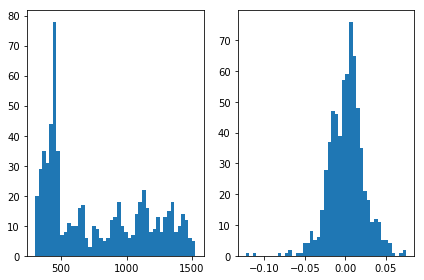

In [10]:
plt.subplot(1, 2, 1)
plt.hist([float(SP500_init[i][1]) for i,j in  enumerate (SP500_init)], bins=45)
plt.subplot(1, 2, 2)
plt.hist(SP500, bins=45)
plt.tight_layout()
plt.show()

L'article propose de représenter graphiquement les cours des 3 variables sur une certaine période. On remarque que nos variations des cours correspondent à l'identique à celle de l'article. 

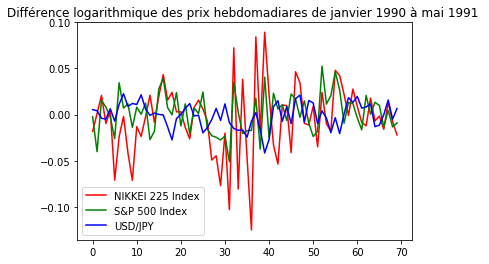

In [11]:
absc = np.linspace(0, 69, 70) # abscisse du graphique (70 points sur notre période)
plt.plot(absc, [NI225[i+1] for i,j in enumerate(NI225) if i<70], 'red', label = "NIKKEI 225 Index")
plt.plot(absc, [SP500[i+1] for i,j in enumerate(SP500) if i<70], 'green', label = "S&P 500 Index")
plt.plot(absc, [USDJPY[i] for i,j in enumerate(USDJPY) if i<70], 'blue', label = "USD/JPY")

plt.legend()
plt.title("Différence logarithmique des prix hebdomadiares de janvier 1990 à mai 1991 ")
plt.show()

Nous rappelons que le but est de prédire la direction du NIKKEI 225. Ainsi, nous devons estimer la direction de l'indice la semaine suivant celle où on observe les prix du SP500 et de la parité USD/JPY. Un décalage d'une semaine de la variable à prédire est à établir.

In [12]:
def signe(nb): # fonction signe. Elle existe dans numpy mais elle renvoit 0 pour 0 ==> possibilité 3 labels (non binaire), même si j'imagine que p.s les prix entre 2 dates différentes sont différents ... 
    if (nb>0):
        return 1
    return -1

Y = [signe(i) for i in NI225] # étiquette binaire des prix NI225 à prédir (+1 si accroissement des prix, -1 sinon)
Y = [Y[i+1] for i in range(len(Y)) if i<len(Y)-1]  # décalage d'une semaine de la variable target

X = list(zip(SP500, USDJPY))  # matrice des variables explicatives
for i,j in enumerate(X):
    X[i] = list(X[i])
del(X[len(X)-1])  # supression de la dernière donnée qui n'a plus de candidat Y

# on suprimme une observation pour avoir le même nombre de point que l'article
del(Y[len(Y)-1])  
del(X[len(X)-1])

L'article propose également d'afficher la matrice de covariance des variables explicatives X en séparant les cas Y=-1 et Y=1. On constate qu'on obtient à peu de chose près les même matrices de covariance.

In [13]:
print("Matrice de covariance de X quand Y=-1 :\n")
print(np.cov(np.array([ [X[i][1] for i in range(len(Y)) if Y[i]==-1], [X[i][0] for i in range(len(Y)) if Y[i]==-1] ])))

print("\nMatrice de covariance de X quand Y=1 :\n")
print(np.cov(np.array([ [X[i][1] for i in range(len(Y)) if Y[i]==1], [X[i][0] for i in range(len(Y)) if Y[i]==1] ])))

Matrice de covariance de X quand Y=-1 :

[[  1.51192946e-04   2.76383115e-05]
 [  2.76383115e-05   4.60026196e-04]]

Matrice de covariance de X quand Y=1 :

[[  1.86444590e-04  -1.28829827e-05]
 [ -1.28829827e-05   5.05689141e-04]]


Nous pouvons à présent séparer l'esemble d'entrainement de l'ensemble test (640 points contre 36 comme mentionné dans l'article).

In [14]:
X_test = [X[i] for i in np.arange(640,676)] 
Y_test = [Y[i] for i in np.arange(640,676)]

X = [X[i] for i in range(640)]
Y = [Y[i] for i in range(640)]

Nous affichons quelques statistiques de nos données entrainées :

In [15]:
import pandas as pd # librairie de manipulation des données

print(pd.DataFrame(X).describe())

                0           1
count  640.000000  640.000000
mean     0.001795   -0.000147
std      0.021302    0.012961
min     -0.123304   -0.083000
25%     -0.011664   -0.007291
50%      0.003074    0.000782
75%      0.013463    0.008437
max      0.074923    0.050358


Ainsi que les données test où on remarque qu'elles sont bien équilibrés au regard de la moyenne sur les 640 points (autant de direction à la hausse qu'à la baisse)

In [16]:
print(pd.DataFrame(Y).describe())

                0
count  640.000000
mean    -0.043750
std      0.999824
min     -1.000000
25%     -1.000000
50%     -1.000000
75%      1.000000
max      1.000000


Avant de se lancer dans les algorithmes, nous allons visualiser nos données (puisque nous sommes dans $ℝ^2$)

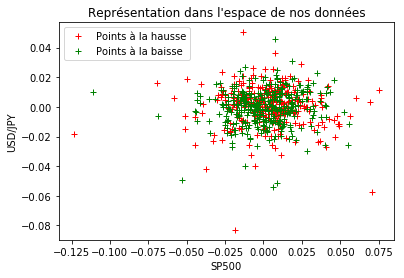

In [17]:
x1=[X[i][0] for i,j in enumerate(X) if Y[i]==1]
y1=[X[i][1] for i,j in enumerate(X) if Y[i]==1]
x2=[X[i][0] for i,j in enumerate(X) if Y[i]==-1]
y2=[X[i][1] for i,j in enumerate(X) if Y[i]==-1]
plt.plot(x1,y1, '+r', label = "Points à la hausse")
plt.plot(x2,y2, '+g', label = "Points à la baisse")

plt.legend()
plt.title("Représentation dans l'espace de nos données")
plt.xlabel('SP500')
plt.ylabel('USD/JPY')
plt.show()

Il est clair qu'une simple séparation linéaire donnera de médiocre résultat. Pour l'algorithme SVM, l'astuce du noyau est donc à mettre en place : les données seront retranscrites dans un espace à plus grande dimension afin d'être mieux séparable par un hyperplan. On obtiendra alors une séparation non linéaire dans l'espace d'origine.

Nous appliquons un premier algorithme de benchmark à savoir le Random Walk (RW) qui renvoie la direction de la semaine en cours pour prédire la direction de la semaine suivante (les variables ecplicatives sont ignorées).

In [18]:
RW = [abs((Y+Y_test)[i+1]-(Y+Y_test)[i])/2 for i in range(len((Y+Y_test))-1)]
print(np.mean(RW))

0.499259259259


Sans surprise, la moitié des directions sont correctes comme trouvé dans l'article.<br><br>
Nous allons à présent tester les algorithmes LDA et QDA. Ce dernier repose sur la formule de Bayes en supposant que la loi de Xi (ième variable explicatives) sachant Y suit une loi gaussienne. La LDA est un cas particulier de la QDA où les variances des loi conditionnelles précédentes sont égales impliquant une frontière de décision moins complexe. Nous comprenons mieux la transformation logarithmique précédente qui engendre un caractère gaussien des variables explicatives.

In [20]:
from sklearn.qda import QDA
from sklearn.lda import LDA

clf_lda = LDA()
clf_qda = QDA()

clf_lda.fit(X, Y)
clf_qda.fit(X, Y)

print("Hit ratio de la LDA : {0}\n".format(clf_lda.score(X_test,Y_test)))
print("Hit ratio de la QDA : {0}".format(clf_qda.score(X_test,Y_test)))

Hit ratio de la LDA : 0.5555555555555556

Hit ratio de la QDA : 0.6111111111111112


On retrouve le même résultat pour la LDA que l'article. Cependant, la performance de notre QDA est bien moins importante que l'auteur (0.61 contre 0.69). Cette différence est à nuancer du fait du faible nombre de point test : nous avons correctement classé 22/36 points contre 25/36 pour l'article. Seul 3 points diffèrent qui peut être dû à un petit décalage dans la séparation entrainement/test des données. 
<U>Remarque</U> : </ul>
Après diverses modifications de la frontière train/test nous obtenons toujours un résultat en dessous de l'article. La différence semble provenir lors de l'importation des données : nous avons choisis de prendre les prix à l'ouverture du marché puisque l'article n'y apporte aucune précision.

<br ><br />
À présent nous allons mettre en place l'algrithme SVM. Comme nous l'avons vu précédemment, on utilise l'astuce du noyau pour passer nos données dans un plan supérieur via une transformation φ afin de séparer les points linéairement. Lors de la résolution KKT du problème d'optimisation de l'hyperplan séparateur, on se retrouve à devoir calculer des produits scalaires entre nos données projetées par φ ce qui s'avère très couteux en calcul. Pour remédier à cela, on introduit une fonction noyau qui égalise le produit scalaire précédent (sous certaines conditions : voir théorème de Mercer). Ainsi au lieu de calculer une grande somme, nous sommes réduits à appliquer l'image de points via la fonctionnelle noyau réduisant considérablement le cout en temps. <br ><br />
L'article suggère d'utiliser un noyau gaussien qui possède un unique paramètre γ. Nous avons également tenté d'appliquer un noyau polynomial mais le nombre important de paramètres à tester lors de la Cross Validation était bien trop couteux.<br ><br />

En plus du paramètre γ, nous devons estimer le paramètre C de l'algorithme SVM qui influence l'acceptation de certains points mal classé (une séparation parfaitement linéaire même dans un espace de grande dimension est quasiment jamais réalisable). Pour avoir une première estimation de ces 2 paramètres on se propose de lancer une Cross Validation sur les fenêtres standards suivantes :

In [21]:
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 4, 8)

print("fenêtre de C :\n {0}\n".format(C_range))
print("fenêtre de γ : \n{0}\n".format(gamma_range))

fenêtre de C :
 [  1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00
   1.00000000e+01   1.00000000e+02   1.00000000e+03]

fenêtre de γ : 
[  1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00
   1.00000000e+01   1.00000000e+02   1.00000000e+03   1.00000000e+04]



On lance une Cross validation shuffle startifiée avec 20% de points test contre 80% de points entrainés. Cette Cross validation consiste à mélanger initialement les données à entrainer puis les séparer en 2 (80% contre 20%) de sorte que la séparation induisent la même proportion initiale des classes représentées dans les 2 sets séparés. Cette opération de séparation stratifiée sera répétée 5 fois. Ici, on a initialement une proportion quasi égale de points à la hausse et à la baisse comme on l'a vu dans le tableau précédemment. Ainsi, les 2 set séparés par la cross validation auront chacun autant de points à la hausse qu'à la baisse. Cette méthode permet d'obtenir un biais moins important sur la performance finale.

In [281]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 4, 8)

for i in range(10):

    param_grid = dict(gamma = gamma_range, C = C_range)
    cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2)
    grid = GridSearchCV(SVC(), param_grid = param_grid, cv = cv)
    grid.fit(X, Y)

    print("Les meilleurs paramètres sont : {0} avec un hit ratio de {1}".format(grid.best_params_, grid.best_score_ ))

Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 1000.0} avec un hit ratio de 0.5453125
Les meilleurs paramètres sont : {'C': 100.0, 'gamma': 100.0} avec un hit ratio de 0.5265625
Les meilleurs paramètres sont : {'C': 10.0, 'gamma': 1000.0} avec un hit ratio de 0.5546875
Les meilleurs paramètres sont : {'C': 1000.0, 'gamma': 100.0} avec un hit ratio de 0.54375
Les meilleurs paramètres sont : {'C': 1000.0, 'gamma': 1000.0} avec un hit ratio de 0.5390625
Les meilleurs paramètres sont : {'C': 100.0, 'gamma': 1000.0} avec un hit ratio de 0.5640625
Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 1000.0} avec un hit ratio de 0.5328125
Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 100.0} avec un hit ratio de 0.5265625
Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 1000.0} avec un hit ratio de 0.546875
Les meilleurs paramètres sont : {'C': 1000.0, 'gamma': 1.0} avec un hit ratio de 0.528125


Nous avons lancé 10 Cross Validation indépendante pour obtenir une zone de recherche plus précise sur la grille des paramètres. Nous pouvons seulement restreindre la zone des valeurs de C de 1 à 5000 et les valeurs de γ de 10 à 1000. <br ><br /> Dans la suite on réitère l'opération précédente sur la nouvelle zone de paramètre pour 10 Cross Validation. De plus, nous représentons graphiquement la valeur du hit ratio pour chaque couple de paramètre accompagné d'une carte de chaleur permettant de repérer facilement les éventuelles zones intéréssantes. Enfin nous introduisons à l'aide de la fonction ci dessous la frontière de décision du SVM des meilleurs paramètres appliquée à la classification des 36 points test.

In [22]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min()-0.01 , X[:, 0].max()+0.01
    x2_min, x2_max = X[:, 1].min() -0.01, X[:, 1].max() +0.01
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1], alpha = 0.8, c = cmap(idx), marker = markers[idx], label = cl)

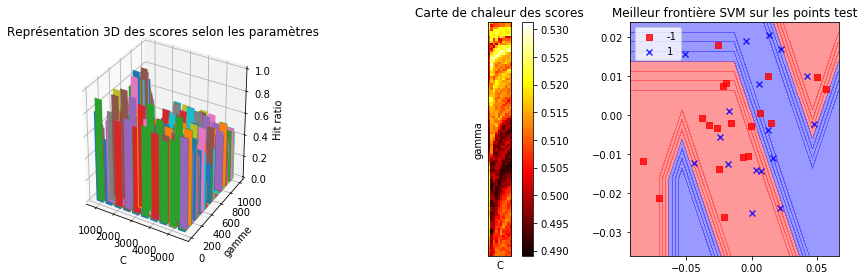

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 1001, 'gamma': 160}


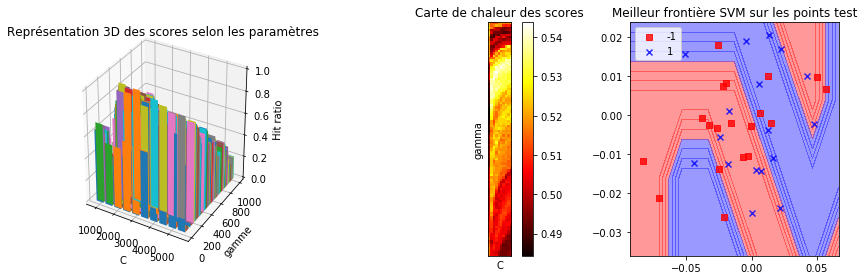

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 1501, 'gamma': 220}


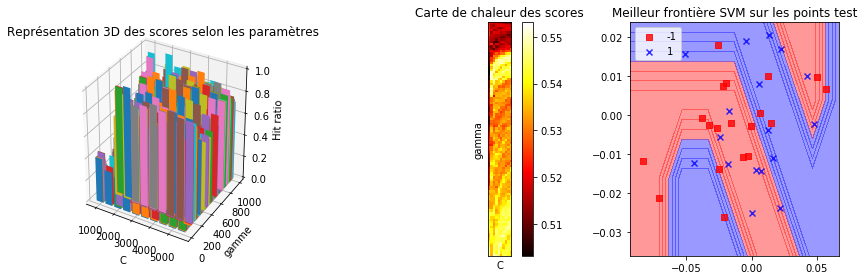

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 1001, 'gamma': 210}


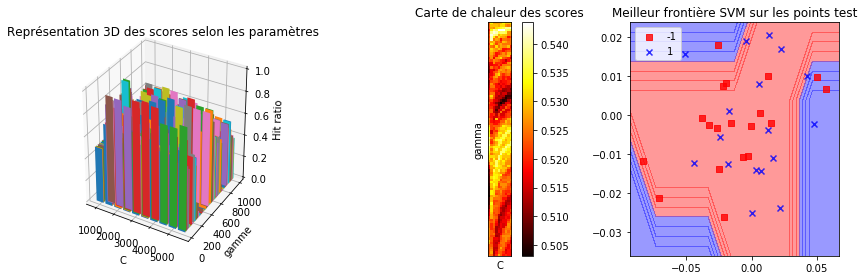

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 2001, 'gamma': 40}


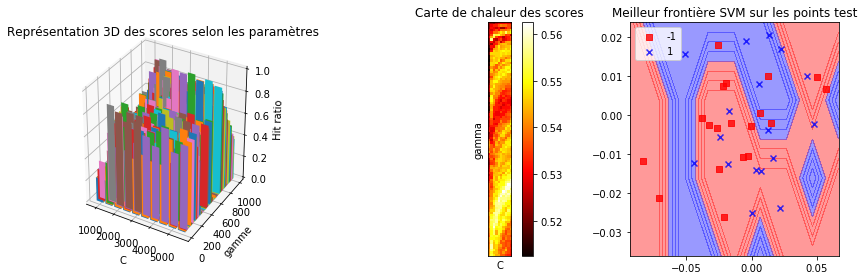

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 3001, 'gamma': 730}


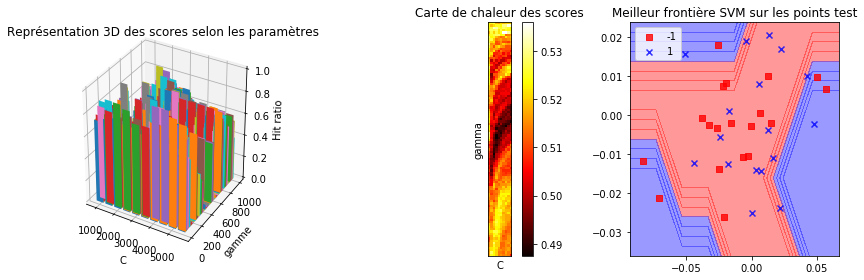

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 3001, 'gamma': 50}


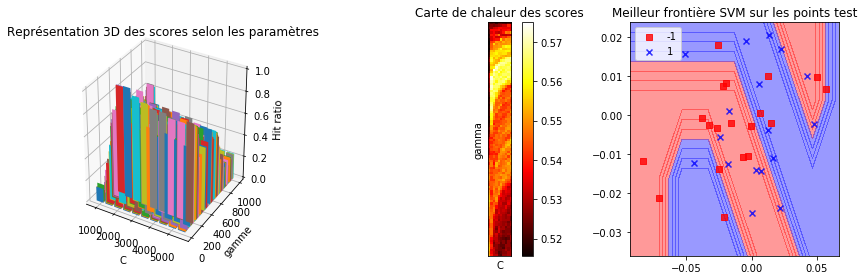

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 1001, 'gamma': 210}


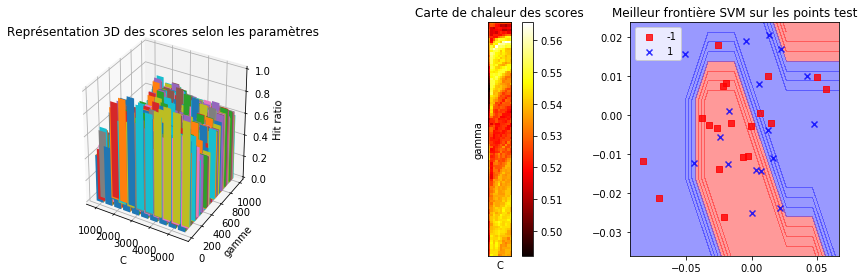

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 3501, 'gamma': 90}


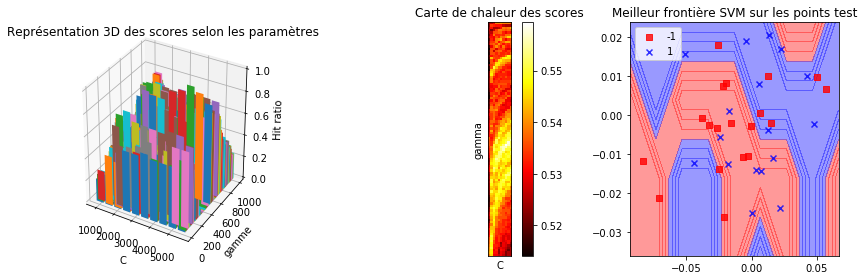

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 3501, 'gamma': 530}


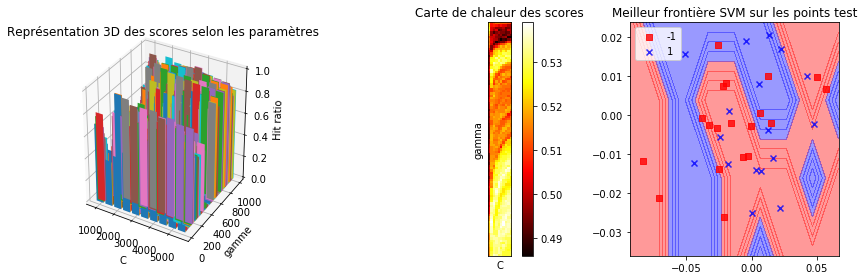

           Les meilleurs paramètres de la simulation ci dessus sont : {'C': 501, 'gamma': 860}


In [1156]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


C_range = np.arange(1, 5000, 500)
gamma_range = np.arange(10, 1001, 10)
param_grid = dict(gamma=gamma_range, C=C_range)


for indice, i in enumerate(range(10)):

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    grid.fit(X, Y)
    
    # on garde les 3 donnée qui nous intéressent (hit ratio, C, gamma)
    scores = pd.DataFrame(grid.cv_results_).reindex(columns = ['mean_test_score', 'param_C', 'param_gamma'])
    scores = scores.sort_values(by = ['param_gamma', 'param_C'])
    scores = scores.set_index('param_gamma')

    down = min(scores['mean_test_score'])
    up = max(scores['mean_test_score'])
    
    # on représente la performance du SVM selon les couples de paramètres
    fig = plt.figure(1, figsize=(12, 4))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    plt.title('Représentation 3D des scores selon les paramètres')
    ax.set_xlabel('C')
    ax.set_ylabel('gamme')
    ax.set_zlabel('Hit ratio')

    for k, z in enumerate(gamma_range):
        
        xs = range(len(C_range))
        ys = (np.array(scores.loc[gamma_range[k]]['mean_test_score'])-down)/(up-down)
        ax.xaxis.set_ticklabels([1000,2000,3000,4000,5000])
        ax.bar(xs, ys, zs=z, zdir='y',  alpha=1)
    
    # on introdut la carte de chaleur
    plt.tight_layout()
    plt.subplot(1, 3, 2)
    plt.imshow([list(scores.loc[gamma_range[i]]['mean_test_score']) for i in range(len(gamma_range))], interpolation='nearest', cmap=plt.cm.hot)
    plt.ylabel('gamma')
    plt.xlabel('C')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Carte de chaleur des scores')
    
    # on trace les frontière avec les points test
    plt.subplot(1, 3, 3)
    clf = SVC(kernel='rbf', gamma=grid.best_params_['gamma'], C=grid.best_params_['C'])
    clf.fit(X, Y)
    plot_decision_regions(np.array(X_test), np.array(Y_test), classifier=clf)
    plt.legend(loc='upper left')
    plt.title('Meilleur frontière SVM sur les points test')

    plt.tight_layout()
    plt.show()
    
    print("           Les meilleurs paramètres de la simulation ci dessus sont : {0}".format(grid.best_params_))

À travers les 2 premieres représentations, on ne peut pas conclure à l'existence d'un unique couple plus performant. Cependant, on remarque que le paramètre γ a une plus grande influence sur la performance du classifieur : pour un γ fixé donnant un hit ratio élévé, quelconque valeur de C associée à γ donnera un hit ratio élevé. On observe facilement cela à l'aide de la carte de chaleur où les zones les plus claire (meilleur résultat) se localisent tout au long de l'absisse C. <br ><br />
Afin de dimuner la variance des meilleurs couples lors des différentes Cross validation shuffle stratifiée, nous décidons d'utiliser la méthode Leave One Out Cross Validation (LOOCV). Cette méthode repose sur un entrainement de toutes les valeurs possibles du train set auquel on a retiré un unique point qui sera testé. On réitère cette opération jusqu'à que tous les points du train set aient été enlevés une unique fois. Ainsi avec cette méthode la Cross Validation ne pourra renvoyer qu'un unique couple quel que soit le nombre de Cross Validation lancée (il n'y a plus d'aléa). 

Nous commencons par normaliser nos données afin qu'elles soient centrées réduites (indépendemment sur chaque variable explicative). Cette transformation permet une réduction du temps d'entrainement du clasifieur SVM grâce à une diminution de la dispertion des données.

In [364]:
from sklearn.preprocessing import StandardScaler # normalisation donnée

scaler = StandardScaler() # normalisation type centré réduite
X = scaler.fit_transform(X) # entrainé sur train set
X_test = scaler.transform(X_test) # appliqué sur le test set

# Attention à Runner cette cellule une unique fois au risque de modifier compléteent X_test

On applique à présent la LOOCV :

In [395]:
from sklearn.model_selection import KFold  


C_range = np.arange(1, 5000, 500)
gamma_range = np.arange(10, 1001, 10)

param_grid = dict(gamma = gamma_range, C = C_range)
cv = KFold(n_splits = len(Y), shuffle = True)                  # Leave one out CV : n_splits = len(Y)
grid = GridSearchCV(SVC(), param_grid = param_grid, cv = cv)
grid.fit(X, Y)

print("Les meilleurs paramètres sont : {0} avec un hit ratio de {1}".format(grid.best_params_, grid.best_score_))

Les meilleurs paramètres sont : {'C': 1, 'gamma': 120} avec un hit ratio de 0.5265625


On entraîne notre SVM avec le couple constant de la LOOCV :

In [401]:
clf = SVC(kernel = 'rbf', gamma = grid.best_params_['gamma'], C = grid.best_params_['C'])
clf.fit(X, Y)
print("Le hit ratio SVM vaut : {0}".format(clf.score(X_test,Y_test)))

Le hit ratio SVM vaut : 0.6666666666666666


On obtient un hit ratio de 66% comparé à 72% de l'auteur ce qui implique seulement une différence de 2 points mal classés (24/36 contre 26/36).<br ><br /><br ><br /> 

<FONT size="5pt">II - <U>Vers un élargissement du test set</U></FONT> 
<br ><br /> 

À présent, on se propose d'augmenter la taille de l'échantillon test puisque comme nous l'avons constaté lors de nos comparaisons de performances, 3 points mal classés suffit à diminuer un hit ratio de près de 10% !
Un échantillon test de 5% des données entrainées nous semble insuffisant. Nous allons importer de nouvelles données pour augmenter ce pourcentage jusqu'à environ 20%.

In [174]:
# NIKKEI 225 Index

NI225_add = open("N225_add.csv", 'r') 
NI225_add = list(csv.reader(NI225_add))
del(NI225_add[0]) 
del(NI225_add[0])
NI225_add =[math.log(float(NI225_add[i+1][4])/float(NI225_add[i][4])) for i,j in enumerate(NI225_add) if(i<len(NI225_add)-1) ][0:78] 

# S&P 500 Index

SP500_add = open("GSPC_add.csv", 'r') 
SP500_add = list(csv.reader(SP500_add))
del(SP500_add[0])
SP500_add = [math.log(float(SP500_add[i+1][4])/float(SP500_add[i][4])) for i,j in enumerate(SP500_add) if(i<len(SP500_add)-1) ][0:78]

# Parité USD/JPY 

USDJPY_add = open("4_add.rtf", 'r')
USDJPY_add = list(csv.reader(USDJPY_add))
for i in range(9):
    del(USDJPY_add[0])
del(USDJPY_add[len(USDJPY_add)-1])
del(USDJPY_add[len(USDJPY_add)-1])
USDJPY_add = [math.log(float(re.sub(r',',r'.', USDJPY_add[i+1][1]))/float(re.sub(r',',r'.', USDJPY_add[i][1]))) for i,j in enumerate(USDJPY_add) if(i<len(USDJPY_add)-1) ][0:78] 

On applique la transformation logarithmique puis on forme les matrices de données

In [175]:
Y_test_add = [signe(i) for i in NI225_add] 
Y_test_add = [Y_test_add[i+1] for i in range(len(Y_test_add)) if i<len(Y_test_add)-1]

X_test_add = list(zip(SP500_add, USDJPY_add))
for i,j in enumerate(X_test_add):
    X_test_add[i] = list(X_test_add[i])
del(X_test_add[len(X_test_add)-1])

On a ajouté 77 nouveaux points qui correspondent à une période d'un an et demi environ (1 point = 1 semaine) :

In [176]:
print(len(X_test_add), len(Y_test_add))

77 77


On oublie pas d'appliquer la transformation centrée réduite sur nos nouvelles données :

In [177]:
X_test_add = scaler.transform(X_test_add)

Puis on applique le même classifieur SVM que précédemment pour la prédiction des anciennes données test ajoutées aux nouvelles.

In [518]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', gamma=120, C=1)
clf.fit(X, Y)
print(clf.score(list(X_test) + list(X_test_add), list(Y_test) + list(Y_test_add))) # ancienne + nouvelles données

0.53982300885


Le taux de prédiction chute drastiquement passant de 67% à 54% ! <br ><br />
On fait de même pour les classifieurs LDA et QDA :

In [367]:
from sklearn.qda import QDA
from sklearn.lda import LDA

clf_lda = LDA()
clf_qda = QDA()

clf_lda.fit(X, Y)
clf_qda.fit(X, Y)

print("Hit ratio de la LDA : {0}\n".format(clf_lda.score(list(X_test) + list(X_test_add),list(Y_test) + list(Y_test_add))))
print("Hit ratio de la QDA : {0}".format(clf_qda.score(list(X_test) + list(X_test_add),list(Y_test) + list(Y_test_add))))

Hit ratio de la LDA : 0.504424778761062

Hit ratio de la QDA : 0.5132743362831859


Il en va de même pour ces 2 classifieurs : on observe une baisse de 5% pour la LDA et 10% pour la QDA.

<br >Une première conclusion est à établir. L'excellente performance des classifieurs (particulièrement du SVM) est à relativiser au vu de son faible nombre de points test. En passant de 36 à 113 points test la performance de nos classifieurs diminue d'environ 10%. <br ><br />
Un second point crucial est à établir : sur les 36 premiers points test le hit ratio du SVM est de 0.66% tandis que sur les 113 points test incluant les 36 premiers points précédents le hit ratio passe à 0.54%. Il semble donc que les points test situés temporellement juste après la fin de la période d'entrainement soient mieux classés. Le graphique suivant permet de confirmer cette hypothèse :

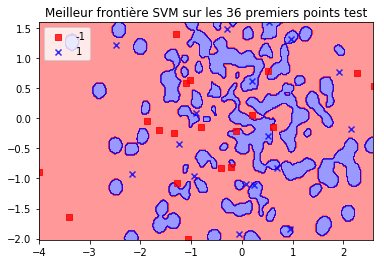

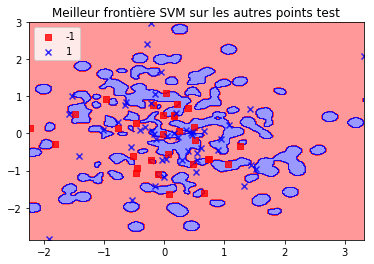

In [456]:
clf = SVC(kernel='rbf', gamma = 120, C = 1)
clf.fit(X, Y)

plot_decision_regions(np.array(X_test), np.array(Y_test), classifier = clf)
plt.legend(loc='upper left')
plt.title('Meilleur frontière SVM sur les 36 premiers points test')
plt.show()

plot_decision_regions(np.array(X_test_add), np.array(Y_test_add), classifier = clf)
plt.legend(loc='upper left')
plt.title('Meilleur frontière SVM sur les autres points test')

plt.show()

Par exemple, sur le premier graphe on remarque que les points test à la hausse sont presque tous bien classés tandis que sur le second, le taux de bon classement semble bien moindre.

<br ><br /> 
<FONT size="5pt">III - <U>Amélioration de la stabilité de la performance</U></FONT> 
<br ><br /> 
On se propose dans cette partie d'améliorer la robustesse du classifieur SVM afin de pallier à l'écart important de performance selon la temporalité des points tests. Nous verrons plus tard en quoi rendre notre classifieur indépendant de la variable temps est primordiale dans une simple stratégie de trading.<br /><br />
La nouvelle méthode employée réside principalement en l'ajout de nouvelles caractériquetiques à nos données. En gardant le même résonnement de l'article, on étend l'analyse de dépendance de l'économie du Japon à celle des Etats-Unis en rajoutant deux autres partenaires commerciaux majeurs : la Chine et L'UE. De ce fait on rajoute naturellement l'indice boursier référence de Shanghai et de l'UE à savoir le SSE et l'Euro Stoxx 50. Il en va de même pour l'ajout des devises CNY/JPY et EUR/JPY. Enfin nous complétons ces données exogènes avec des capteurs intrinsèque à l'économie du Japon : les taux d'intérêt des obligation d'État pour différentes maturités (1, 2, 3, 5, 7, 10 et 15 ans)<br /><br />
La période d'importation des données coïncide avec celle de l'article décallé d'un an (mais toujours avec le même nombre d'observation à savoir 540+36) pour cause de donnée absente. Ces données sont également obtenues via le moteur de recherche "Yahoo finance", le site du professeur Werner Antweiler ainsi que le site "Investing" pour les bonds. Certaines données pour la parité CNY/JPY étaient manquantes. Pour les retrouver, on s'est simplement servi de la devise CNY/EUR et EUR/JPY pour retrouver celle de CNY/JPY, en supposant une absence d'opportunité d'arbitrage.

In [24]:
import numpy as np 
import csv 
import re  

# Importation des taux d'intérêts long terme

YB1 = open("1yearbond.rtf",'r') 
YB1 = list(csv.reader(YB1)) 
for i in range(9):
    del(YB1[0])
del(YB1[len(YB1)-1])
del(YB1[len(YB1)-1])
YB1 = [math.log(float(YB1[i+1][2])/float(YB1[i][2])) for i,j in enumerate(YB1) if(i<len(YB1)-1) ]

YB2 = open("2yearbond.rtf",'r') 
YB2 = list(csv.reader(YB2)) 
for i in range(9):
    del(YB2[0])
del(YB2[len(YB2)-1])
del(YB2[len(YB2)-1])
YB2 = [math.log(float(YB2[i+1][2])/float(YB2[i][2])) for i,j in enumerate(YB2) if(i<len(YB2)-1) ]

YB3 = open("3yearbond.rtf",'r') 
YB3 = list(csv.reader(YB3)) 
for i in range(9):
    del(YB3[0])
del(YB3[len(YB3)-1])
del(YB3[len(YB3)-1])
YB3 = [math.log(float(YB3[i+1][2])/float(YB3[i][2])) for i,j in enumerate(YB3) if(i<len(YB3)-1) ]

YB5 = open("5yearbond.rtf",'r') 
YB5 = list(csv.reader(YB5)) 
for i in range(9):
    del(YB5[0])
del(YB5[len(YB5)-1])
del(YB5[len(YB5)-1])
YB5 = [math.log(float(YB5[i+1][2])/float(YB5[i][2])) for i,j in enumerate(YB5) if(i<len(YB5)-1) ]

YB7 = open("7yearbond.rtf",'r') 
YB7 = list(csv.reader(YB7)) 
for i in range(9):
    del(YB7[0])
del(YB7[len(YB7)-1])
del(YB7[len(YB7)-1])
YB7 = [math.log(float(YB7[i+1][2])/float(YB7[i][2])) for i,j in enumerate(YB7) if(i<len(YB7)-1) ]

YB10 = open("10yearbond.rtf",'r') 
YB10 = list(csv.reader(YB10)) 
for i in range(9):
    del(YB10[0])
del(YB10[len(YB10)-1])
del(YB10[len(YB10)-1])
YB10 = [math.log(float(YB10[i+1][2])/float(YB10[i][2])) for i,j in enumerate(YB10) if(i<len(YB10)-1) ]

YB15 = open("15yearbond.rtf",'r') 
YB15 = list(csv.reader(YB15)) 
for i in range(9):
    del(YB15[0])
del(YB15[len(YB15)-1])
del(YB15[len(YB15)-1])
YB15 = [math.log(float(YB15[i+1][2])/float(YB15[i][2])) for i,j in enumerate(YB15) if(i<len(YB15)-1) ]

# Importation des Indices boursiers

NI225bis = open("N225bis.csv", 'r') 
NI225bis = list(csv.reader(NI225bis)) 
del(NI225bis[0]) 
NI225bis =[math.log(float(NI225bis[i+1][1])/float(NI225bis[i][1])) for i,j in enumerate(NI225bis) if(i<len(NI225bis)-1) ] 

SP500bis = open("GSPCbis.csv", 'r')
SP500bis = list(csv.reader(SP500bis))
del(SP500bis[0]) 
SP500bis =[math.log(float(SP500bis[i+1][1])/float(SP500bis[i][1])) for i,j in enumerate(SP500bis) if(i<len(SP500bis)-1) ] 

STOXX50E = open("STOXX50E.csv", 'r') 
STOXX50E = list(csv.reader(STOXX50E)) 
del(STOXX50E[0]) 
STOXX50E =[math.log(float(STOXX50E[i+1][1])/float(STOXX50E[i][1])) for i,j in enumerate(STOXX50E) if(i<len(STOXX50E)-1) ] 

SSE = open("SSE.csv", 'r') 
SSE = list(csv.reader(SSE)) 
del(SSE[0]) 
SSE =[math.log(float(SSE[i+1][1])/float(SSE[i][1])) for i,j in enumerate(SSE) if(i<len(SSE)-1) ]

# Importation des parités sur devise

USDJPYbis = open("USDJPYbis.rtf", 'r')
USDJPYbis = list(csv.reader(USDJPYbis)) 
for i in range(9):
    del(USDJPYbis[0])
del(USDJPYbis[len(USDJPYbis)-1])
del(USDJPYbis[len(USDJPYbis)-1])

CNYJPY = open("CNYJPY.rtf", 'r') 
CNYJPY = list(csv.reader(CNYJPY)) 
for i in range(9):
    del(CNYJPY[0])
del(CNYJPY[len(CNYJPY)-1])
del(CNYJPY[len(CNYJPY)-1])

CNYEUR = open("CNYEUR.rtf", 'r') 
CNYEUR = list(csv.reader(CNYEUR)) 
for i in range(9):
    del(CNYEUR[0])
del(CNYEUR[len(CNYEUR)-1])
del(CNYEUR[len(CNYEUR)-1])

EURJPY = open("EURJPY.rtf", 'r') 
EURJPY = list(csv.reader(EURJPY)) 
for i in range(9):
    del(EURJPY[0])
del(EURJPY[len(EURJPY)-1])
del(EURJPY[len(EURJPY)-1])

CNYJPY = [ "%.4f" % (float(re.sub(r',',r'.', CNYEUR[i][2])) * float(re.sub(r',',r'.', EURJPY[i][2]))) for i in range(len(CNYEUR)) ] + [ CNYJPY[i][2] for i in range(len(CNYJPY)) ]

USDJPYbis =[math.log(float(re.sub(r',',r'.', USDJPYbis[i+1][2]))/float(re.sub(r',',r'.', USDJPYbis[i][2]))) for i,j in enumerate(USDJPYbis) if(i<len(USDJPYbis)-1) ] 
EURJPY =[math.log(float(re.sub(r',',r'.', EURJPY[i+1][2]))/float(re.sub(r',',r'.', EURJPY[i][2]))) for i,j in enumerate(EURJPY) if(i<len(EURJPY)-1) ] 
CNYJPY =[math.log(float(CNYJPY[i+1])/float(CNYJPY[i])) for i,j in enumerate(CNYJPY) if(i<len(CNYJPY)-1) ] 

On vérifie que le cardinal des listes coïncident

In [25]:
print(len(CNYJPY), len(NI225bis), len(EURJPY), len(USDJPYbis), len(SP500bis), len(STOXX50E), len(SSE))

678 678 678 678 678 678 678


On affiche l'histogramme de nos 13 variables explicatives et on observe bien que la transformation logarithmique engendre un caractère gaussien.

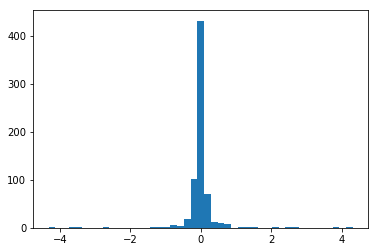

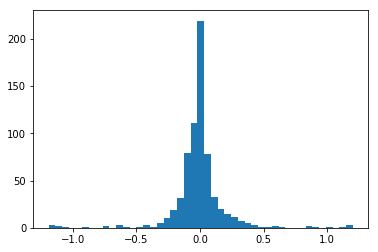

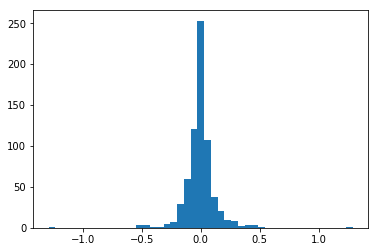

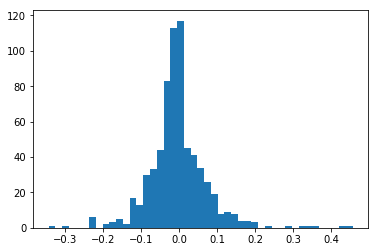

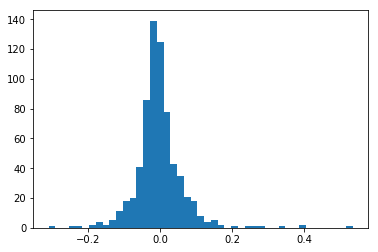

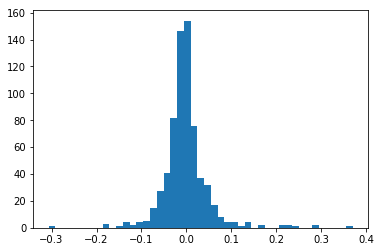

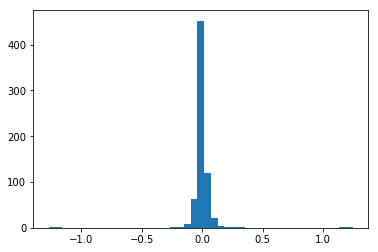

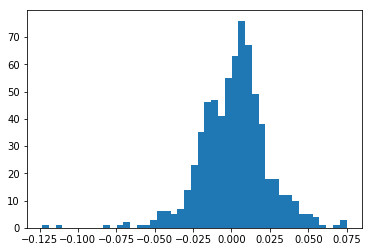

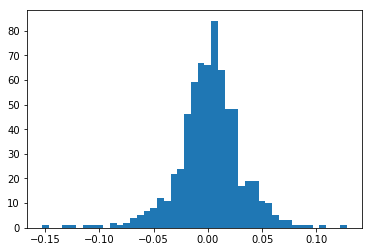

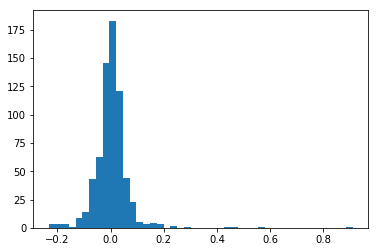

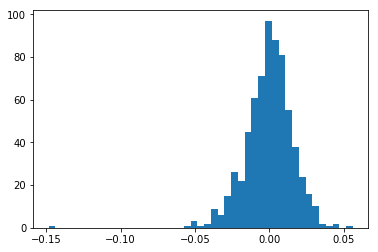

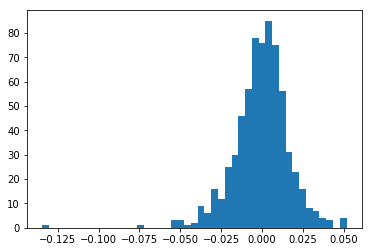

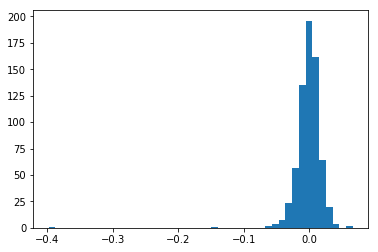

In [540]:
names = [YB1, YB2, YB3, YB5, YB7, YB10, YB15, SP500bis, STOXX50E, SSE, USDJPYbis, EURJPY, CNYJPY]

for i in names:
    plt.hist(i, bins=45)
    plt.show()

On forme nos matrices de données :

In [541]:
V = [signe(i) for i in NI225bis] # étiquette binaire des prix NI225 à prédir (+1 si accroissement des prix, -1 sinon)
V = [V[i+1] for i in range(len(V)) if i<len(V)-1]

U = list(zip(YB1, YB2, YB3, YB5, YB7, YB10, YB15, SP500bis, STOXX50E, SSE, USDJPYbis, EURJPY, CNYJPY))
for i,j in enumerate(U):
    U[i] = list(U[i])
del(U[len(U)-1])

del(V[len(V)-1])
del(U[len(U)-1])

U_test = [U[i] for i in np.arange(640,676)]
V_test = [V[i] for i in np.arange(640,676)]
U_train = [U[i] for i in range(640)]
V_train = [V[i] for i in range(640)]

On s'assure de la bonne dimension de notre matrice d'entrainement

In [542]:
print(np.shape(U))

(676, 13)


Dans les précédents histogrammes, on constate que certaines valeurs semblent aberrantes (trop éloignées de la moyenne). Dans le cas d'une variable gaussienne on a que 99.73% des données sont situéss dans l'intervalle  [μ-3σ;μ+3σ] soit seulement 2 points (parmi les 640 à entrainer) en dehors de l'intervalle. Nous ramenons les données hors de l'intervalle à la borne la plus proche de l'intervalle afin de se raprocher d'une distribution gaussienne permettant d'améliorer les performances et le temps de calcul. 

In [543]:
σ = []
μ = []
data_limite = []

for i in range(len(U_train[0])):
    μ.append(np.mean(np.array(U_train)[:,i]))
    σ.append(np.std(np.array(U_train)[:,i]))
    s=0
    for j in range(len(np.array(U_train)[:,i])):
        if (U_train[j][i] < μ[i]-3*σ[i]):
            U_train[j][i] = μ[i]-3*σ[i]
            s+=1
        if (U_train[j][i] > μ[i]+3*σ[i]):
            U_train[j][i] = μ[i]+3*σ[i]
            s+=1
    data_limite.append(s)
print("Nombre de données aberrantes pour chacune des variables explicatives : \n{0}".format(data_limite))

Nombre de données aberrantes pour chacune des variables explicatives : 
[11, 17, 12, 9, 9, 15, 4, 10, 9, 10, 5, 6, 2]


<U>Rappel</U> : il est important de calibrer la transformation sur l'ensemble d'entrainement puis de l'appliquer aux données test : le test set est toujours censé inconnu !

In [486]:
for i in range(len(U_test[0])):
    for j in range(len(np.array(U_test)[:,i])):
        
        if (U_test[j][i] < μ[i]-3*σ[i]):
            U_test[j][i] = μ[i]-3*σ[i]
            
        if (U_test[j][i] > μ[i]+3*σ[i]):
            U_test[j][i] = μ[i]+3*σ[i]

Nous appliquons ensuite une normalisation des données afin que chaque variables explicatives soient dans l'intervalle [-1,1]. Cela permet un gain de temps considérable lors de la calibration des classifieurs en grande dimension (13 ici) ainsi qu'une amélioration des résultats.

In [487]:
min_normalize = []
max_normalize = []

for i in range(len(U_train[0])):
    min_normalize.append(min(np.array(U_train)[:,i]))
    max_normalize.append(max(np.array(U_train)[:,i]))
    for j in range(len(np.array(U_train)[:,i])):
        U_train[j][i] = (2*(U_train[j][i]) - min_normalize[i] - max_normalize[i]) / (max_normalize[i] - min_normalize[i])

On applique la normalisation sur le test set :

In [488]:
for i in range(len(U_test[0])):
    for j in range(len(np.array(U_test)[:,i])):
        U_test[j][i] = (2*(U_test[j][i]) - min_normalize[i] - max_normalize[i]) / (max_normalize[i] - min_normalize[i])

On observe dans le tableau résumé suivant que notre matrice d'entrainement est bien normalisée avec une dispersion des données moindres.

In [500]:
print(pd.DataFrame(U_train).describe())

               0           1           2           3           4           5   \
count  640.000000  640.000000  640.000000  640.000000  640.000000  640.000000   
mean     0.002018    0.000792    0.001571    0.000401   -0.002036   -0.001725   
std      0.195233    0.259558    0.270963    0.315360    0.304202    0.293057   
min     -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
25%     -0.037955   -0.094908   -0.106167   -0.139263   -0.155576   -0.142205   
50%      0.005246    0.001704    0.004290   -0.009511   -0.026632   -0.007473   
75%      0.027068    0.076972    0.106689    0.144528    0.128332    0.126398   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  640.000000  640.000000  640.000000  640.000000  640.000000  640.000000   
mean     0.000320    0.002850    0.002432   -0.010943    0.003227    0.003326   
std      0.148992    0.3195

Nous testons une première grille générale de paramètre pour le SVM (C et γ).

In [1489]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

for i in range(10):

    C_range = np.logspace(-3, 3, 7)
    gamma_range = np.logspace(-5, 4, 10)
    param_grid = dict(gamma = gamma_range, C = C_range)
    cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2)
    grid = GridSearchCV(SVC(), param_grid = param_grid, cv = cv)
    grid.fit(U_train, V_train)

    print("Les meilleurs paramètres sont : {0} avec un hit ratio de {1}".format(grid.best_params_, grid.best_score_ ))

Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 0.10000000000000001} avec un hit ratio de 0.5703125
Les meilleurs paramètres sont : {'C': 10.0, 'gamma': 0.01} avec un hit ratio de 0.55625
Les meilleurs paramètres sont : {'C': 100.0, 'gamma': 0.001} avec un hit ratio de 0.5765625
Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 0.10000000000000001} avec un hit ratio de 0.58125
Les meilleurs paramètres sont : {'C': 1000.0, 'gamma': 0.0001} avec un hit ratio de 0.5875
Les meilleurs paramètres sont : {'C': 1000.0, 'gamma': 0.001} avec un hit ratio de 0.5875
Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 0.10000000000000001} avec un hit ratio de 0.58125
Les meilleurs paramètres sont : {'C': 100.0, 'gamma': 0.01} avec un hit ratio de 0.596875
Les meilleurs paramètres sont : {'C': 100.0, 'gamma': 0.01} avec un hit ratio de 0.59375
Les meilleurs paramètres sont : {'C': 1.0, 'gamma': 0.10000000000000001} avec un hit ratio de 0.5859375


On affine la fenêtre γ allant de 10<sup>-3</sup> à 1 pour un pas de 10<sup>-2</sup>. $C\in$ {1, 10, 100, 1000}

In [1500]:
from sklearn.model_selection import KFold


C_range = [1, 10, 100, 1000]
gamma_range = np.arange(0.001, 1, 0.01)

param_grid = dict(gamma = gamma_range, C = C_range)
cv = KFold(n_splits = len(V_train), shuffle = True)                  # Leave one out CV : n_splits=len(Y)
grid = GridSearchCV(SVC(), param_grid = param_grid, cv = cv)
grid.fit(U_train, V_train)

print("Les meilleurs paramètres sont : {0} avec un hit ratio de {1}".format(grid.best_params_, grid.best_score_ ))

Les meilleurs paramètres sont : {'C': 10, 'gamma': 0.20099999999999996} avec un hit ratio de 0.5828125


In [494]:
clf = svm.SVC(kernel = 'rbf',gamma = 0.201, C = 10)
clf.fit(U_train, V_train)
print("Le score du meilleur classifieur SVM sur 36 points test vaut : \n{0}".format(clf.score(U_test, V_test)))

Le score du meilleur classifieur SVM sur 36 points test vaut : 
0.5277777777777778


Le résultat est décevant (mais est encore une fois à relativiser étant donné de la faible étendue des points test). Nous allons appliquer une réduction de dimension via la meilleure des 2 méthodes suivantes : le F_test de l'ANOVA (analyse de la variance) et l'ACP. <br ><br />
Nous allons donc créer notre propre Cross Validation afin d'intégrer ces méthodes de réduction et d'enregistrer quelues informations. La réduction est apprise sur le set d'entrainement puis appliquer sur le test set qui ont été préalablement séparés. Puis nous prédisons les points test à l'aide des 2 meilleurs classifieurs (SVM et QDA). <br ><br />
La Cross Validation crée est de type K fold : on mélange initialement et une unique fois nos données puis on les sépare en K set. À chaque k$\in$K itération un set correspond au test set et les K-1 autres sont les train set. <br ><br />
Nous prenons K=640 c'est à dire qu'il s'agit d'une LOOCV qui va permettre d'éradiquer la variabilité des meilleurs paramètres à chaque nouvelle Cross Validation pour le SVM comme nous l'avons observé dans la première partie.

In [1490]:
from sklearn.lda import LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif

n = len(V_train)
nb_bloc = int(n)  # nombre de bloc pour la cross validation : leave one out cross validation (1 point test par CV)


indice = np.random.choice(range(n), n, replace = False)  # mélange aléatoire des n indices
indice_test = indice.reshape(nb_bloc, int(n / nb_bloc))  # on coupe le tableau d'indice précédent en 20 blocs. Chaques blocs n°i représentent les indices test lors de la ième validation 

new_U = np.array([ [U_train[j] for j in indice if j not in indice_test[i]] for i in range(nb_bloc) ])  # tableau d'entrainement sur chaques blocs
new_V = np.array([ [V_train[j] for j in indice if j not in indice_test[i]] for i in range(nb_bloc) ]) # tableau d'entrainement sur chaques blocs

information = []
information.append([])  # variance expliquée par l'ACP pour différentes réductions de dimension
information.append([])  # feature sélectionner parmi les 13 pour différentes réductions de dimension

def CV_reduction_dim(classifieur, U_train, V_train, new_U, new_V, bloc, dim):  # moyenne des erreurs de prédiction sur un bloc
    
    score = []
    
    pca = PCA(n_components = dim)
    new_U_transfo = pca.fit_transform(new_U[bloc])
    U_train_transfo = pca.transform(U_train)
    if (bloc == 0 and classifieur == "svm"):   # on ajoute l'information de l'ACP seulement sur un bloc et pour un classifieur (car le résultat sera presque le même quelque soit le bloc et classifieur pour un nombre de dimension fixé)
        information[0].append(sum(pca.explained_variance_ratio_))
    if (classifieur == "qda"):
        clf = QDA()
    if (classifieur == "svm"):
        clf = svm.SVC(kernel = 'rbf',gamma = 0.001, C = 1000)
    clf.fit(new_U_transfo, new_V[bloc]) 
    score.append(1-np.mean([ np.abs(V_train[j]-clf.predict([U_train_transfo[j]]))/2 for j in indice_test[bloc] ]))
    
    select = SelectKBest(f_classif, k = dim)
    new_U_transfo = select.fit_transform(new_U[bloc], new_V[bloc])
    if (bloc == 0 and classifieur == "svm"):
        information[1].append(list(select.get_support(True)))
    U_train_transfo = select.transform(U_train)
    if (classifieur == "qda"):
        clf = QDA()
    if (classifieur == "svm"):
        clf = svm.SVC(kernel = 'rbf',gamma = 0.01, C = 1)
    clf.fit(new_U_transfo, new_V[bloc])
    score.append(1-np.mean([ np.abs(V_train[j]-clf.predict([U_train_transfo[j]]))/2 for j in indice_test[bloc] ]))

    return score

def best_reduction_dim(classifieur, U_train, V_train, new_U, new_V, nb_bloc, dim):  # moyenne des erreurs de prédiction sur tous les blocs
    
    total = [CV_reduction_dim(classifieur, U_train, V_train, new_U, new_V, bloc, dim) for bloc in range (nb_bloc)]
    return [np.mean(np.array(total)[:,i]) for i in range (2)]

On applique une LOOCV pour un classifieur QDA et SVM pour des réduction de dimension dans {2, 4, 6, 8, 10, 12}

In [ ]:
score_QDA = np.array([best_reduction_dim("qda", U_train, V_train, new_U, new_V, nb_bloc, dim) for dim in np.arange(2,13,2)])
score_svm = np.array([best_reduction_dim("svm", U_train, V_train, new_U, new_V, nb_bloc, dim) for dim in np.arange(2,13,2)])

On affiche graphiquement nos résultats pour obtenir un aspect plus visuel

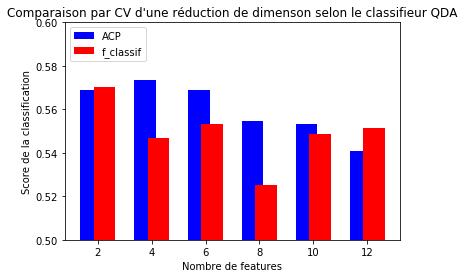

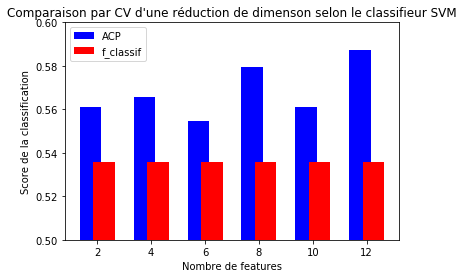

In [1491]:
colors = 'br'

plt.bar(np.arange(1,12,2) + 0.75 , score_QDA[:,0], label="ACP", color=colors[0])  # performances QDA
plt.bar(np.arange(3,14,2) -0.75, score_QDA[:,1], label="f_classif", color=colors[1])
plt.title("Comparaison par CV d'une réduction de dimenson selon le classifieur QDA")
plt.xlabel('Nombre de features')
plt.ylabel('Score de la classification')
plt.ylim((0.5, 0.6))
plt.legend(loc='upper left')
plt.show()

plt.bar(np.arange(1,12,2) + 0.75 , score_svm[:,0], label="ACP", color=colors[0]) # performances SVM
plt.bar(np.arange(3,14,2) -0.75, score_svm[:,1], label="f_classif", color=colors[1])
plt.title("Comparaison par CV d'une réduction de dimenson selon le classifieur SVM")
plt.xlabel('Nombre de features')
plt.ylabel('Digit classification accuracy')
plt.ylabel('Score de la classification')
plt.ylim((0.5, 0.6))
plt.legend(loc='upper left')
plt.show()

Il est clair que la méthode de réduction ACP produit de meilleur performance que le F_test. Par la suite nous travaillerons donc avec l'ACP. Cette meilleure performance peut s'expliquer par le fait que l'ACP réduit la dimension tout en gardant les 13 caractéristiques : en projectant nos données dans un espace inférieur, chaque dimension est représentée par "une combinaison" des 13 caractéristiques initiales. À l'inverse, le F-test réduit la dimension de façon drastique en supprimmant certaines caractéristiques diminuant la diversité des informations. Or ici c'est cette diversité qui semble influencer la performance des classifieurs (du moins pour la QDA). <br ><br />

On affiche les différentes informations enregistrées lors de la cross validation. Pour l'ACP on a calculé le pourcentage de variance expliqué pour chaque dimension. En effet, en projetant nos points dans un espace inférieur, la dispersion des points sera contraintes d'être réduites impliquant une baisse de l'information captée dans ce nouveau plan comparé à l'original.<br ><br />
On affiche également les meilleures caractéristiques gardées par le F_test expliquant le mieux la variable à expliquer pour chaque dimension fixé.

In [1494]:
names = ['YB1', 'YB2', 'YB3', 'YB5', 'YB7', 'YB10', 'YB15', 'SP500bis', 'STOXX50E', 'SSE', 'USDJPYbis', 'EURJPY', 'CNYJPY']

print("Pourcentage de variance expliquée par l'ACP : \n")

for indice, i in enumerate(information[0]):

    print(("    dimension {0} : {1}".format(2*(indice+1), i)))

print("\nFeature selection par 'f_classif' : \n")

for indice, i in enumerate(information[1]):

    print(("    {0} meilleures features : {1}".format(2*(indice+1),np.array(names)[i].tolist())))

Pourcentage de variance expliquée par l'ACP : 

    dimension 2 : 0.5243667410657987
    dimension 4 : 0.7500521497651055
    dimension 6 : 0.8705623964664361
    dimension 8 : 0.9451457380415073
    dimension 10 : 0.9808822683663804
    dimension 12 : 0.9964776114018291

Feature selection par 'f_classif' : 

    2 meilleures features : ['YB5', 'YB10']
    4 meilleures features : ['YB3', 'YB5', 'YB7', 'YB10']
    6 meilleures features : ['YB2', 'YB3', 'YB5', 'YB7', 'YB10', 'STOXX50E']
    8 meilleures features : ['YB2', 'YB3', 'YB5', 'YB7', 'YB10', 'YB15', 'STOXX50E', 'USDJPYbis']
    10 meilleures features : ['YB1', 'YB2', 'YB3', 'YB5', 'YB7', 'YB10', 'YB15', 'STOXX50E', 'SSE', 'USDJPYbis']
    12 meilleures features : ['YB1', 'YB2', 'YB3', 'YB5', 'YB7', 'YB10', 'YB15', 'SP500bis', 'STOXX50E', 'SSE', 'USDJPYbis', 'EURJPY']


Nous choisirons pour l'ACP la plus petite dimension qui a un pourcentage de variance expliqué supérieur à 90% à savoir l'espace de retranscription à 8 dimension.  <br ><br />
D'autre part, le F_test indique que les obligations d'États ont une plus grande influence sur la prédiction (et plus particulièrement celle à plus grande maturité). Cela peut s'expliquer simplement par le fait que ce sont des variables endogènes et liées directement à la condition économique du Japon.

Ainsi, on applique l'ACP à 8 dimension avec le classifieur SVM pour la même fenêtre de paramètre que précédement :

In [1495]:
from sklearn.decomposition import PCA
import time

C_range = [1, 10, 100, 1000]
gamma_range = np.arange(0.001, 1, 0.01)


def erreur_LOOCV(gamma, c, U_train, V_train, bloc): 
    
    pca = PCA(n_components = 8)
    U_train_transfo = pca.fit_transform( np.array(U_train)[ [i for i in range(len(V_train)) if i != bloc] ,:] )
    U_test_transfo = pca.transform( np.array(U_train[bloc]).reshape(1, -1) )
    clf = svm.SVC(kernel = 'rbf', gamma = gamma, C = c)
    clf.fit(U_train_transfo, [V_train[i] for i in range(len(V_train)) if i != bloc]) 
    
    return (np.abs(V_train[bloc] - clf.predict(U_test_transfo))/2)


def erreur_total_LOOCV(gamma, c, U_train, V_train):  # moyenne des erreurs de prédiction sur tous les blocs
    
    return 1-np.mean([erreur_LOOCV(gamma, c, U_train, V_train, bloc) for bloc in range (len(V_train))])


cv = []
for c in C_range:
    er = []
    temps = time.time()
    for gamma in gamma_range:
        er.append(erreur_total_LOOCV(gamma, c, U_train, V_train))
    print(time.time() - temps)
    cv.append(er)

999.1447610855103
1264.0780181884766
3056.491126060486
14342.772699832916


On affiche les meilleurs couple (C, γ)

In [1496]:
best_score = max([max(i) for i in cv])
for indice_C in range(len(C_range)):
    for indice_gamma in range(len(gamma_range)):
        if(cv[indice_C][indice_gamma] == best_score):
            print(C_range[indice_C], gamma_range[indice_gamma], cv[indice_C][indice_gamma])

1 0.061 0.58125
1 0.231 0.58125
10 0.111 0.58125


On applique notre SVM pour la prédiction de nos 36 points test :

In [506]:
pca = PCA(n_components = 8)
U_train_transfo = pca.fit_transform(U_train)
U_test_transfo = pca.transform(U_test)

clf = svm.SVC(kernel='rbf',gamma = 0.111, C = 10)
clf.fit(U_train_transfo, V_train)
print("Le hit ratio du meilleur SVM avec ACP à 8 dimension vaut : \n{0}".format(clf.score(U_test_transfo, V_test)))

Le hit ratio du meilleur SVM avec ACP à 8 dimension vaut : 
0.5277777777777778


On obtient le même score que sans ACP ce qui n'amélirore pas la performance (du moins sur les test set de seulement 36 points). Le score semble tout même bien bas comparé aux résultats du SVM dans la première partie. Nous allons analyser de plus près notre ensemble test en calculant le pourcentage de points à la hausse.

In [515]:
count_train_init = 0  #  partie I
count_test_init = 0  
count_train = 0  # partie III
count_test = 0

for i in range(len(V_train)):
        
    if (Y[i]==1):
        count_train_init = count_train_init + 1
        
    if (V_train[i]==1):
        count_train = count_train + 1

        
for i in range(len(V_test)):
    
    if (Y_test[i]==1):
        count_test_init = count_test_init + 1
    
    if (V_test[i]==1):
        count_test = count_test + 1
        
print("Sur les données à 13 caractéristiques :\n")        
print("Proportion de point d'entrainement à la hausse : {0}".format(count_train / len(V_train)))
print("Proportion de point test à la hausse : {0}\n\n".format(count_test / len(V_test)))
 
print("Sur les données à 2 caractéristiques :\n")   
print("Proportion de point train à la hausse : {0}".format(count_train_init / len(Y)))
print("Proportion de point test à la hausse : {0}".format(count_test_init / len(Y_test)))


Sur les données à 13 caractéristiques :

Proportion de point d'entrainement à la hausse : 0.4640625
Proportion de point test à la hausse : 0.6944444444444444


Sur les données à 2 caractéristiques :

Proportion de point train à la hausse : 0.478125
Proportion de point test à la hausse : 0.4722222222222222


<br ><br />Ainsi la faible performance des classifieurs sur les données de cette partie s'explique par une proportion de points test à la hausse beacoup plus important que sur le train set. Cette disproportion engendre inévitablement de faibles résultats dû au fait que la Cross Validation type LOOCV s'entraine sur tout le train set moins un point. Ainsi les meilleurs couples renvoyés seront plus efficaces pour la prédiction sur un test set non disproportionné.<br ><br />
Nous pouvons donc ingnorer les résultats des 2 classifieurs SVM précédents avec et sans ACP. On décide d'augmenter le test set comme dans la seconde partie de sorte à obtenir eniron 20% de points test et 80% de points d'entrainement.

In [191]:
import numpy as np # package manipulation matricielle
import csv # package manipulation donnée format csv (typique excel)
import re  # package regex

# Importation des taux d'intérêts long terme

YB1_add = open("1yearbond_add.rtf",'r') 
YB1_add = list(csv.reader(YB1_add)) 
for i in range(9):
    del(YB1_add[0])
del(YB1_add[len(YB1_add)-1])
del(YB1_add[len(YB1_add)-1])
YB1_add = [math.log(float(YB1_add[i+1][2])/float(YB1_add[i][2])) for i,j in enumerate(YB1_add) if(i<len(YB1_add)-1) ][0:78]

YB2_add = open("2yearbond_add.rtf",'r') 
YB2_add = list(csv.reader(YB2_add)) 
for i in range(9):
    del(YB2_add[0])
del(YB2_add[len(YB2_add)-1])
del(YB2_add[len(YB2_add)-1])
YB2_add = [math.log(float(YB2_add[i+1][2])/float(YB2_add[i][2])) for i,j in enumerate(YB2_add) if(i<len(YB2_add)-1) ][0:78]

YB3_add = open("3yearbond_add.rtf",'r') 
YB3_add = list(csv.reader(YB3_add)) 
for i in range(9):
    del(YB3_add[0])
del(YB3_add[len(YB3_add)-1])
del(YB3_add[len(YB3_add)-1])
YB3_add = [math.log(float(YB3_add[i+1][2])/float(YB3_add[i][2])) for i,j in enumerate(YB3_add) if(i<len(YB3_add)-1) ][0:78]

YB5_add = open("5yearbond_add.rtf",'r') 
YB5_add = list(csv.reader(YB5_add)) 
for i in range(9):
    del(YB5_add[0])
del(YB5_add[len(YB5_add)-1])
del(YB5_add[len(YB5_add)-1])
YB5_add = [math.log(float(YB5_add[i+1][2])/float(YB5_add[i][2])) for i,j in enumerate(YB5_add) if(i<len(YB5_add)-1) ][0:78]

YB7_add = open("7yearbond_add.rtf",'r') 
YB7_add = list(csv.reader(YB7_add)) 
for i in range(9):
    del(YB7_add[0])
del(YB7_add[len(YB7_add)-1])
del(YB7_add[len(YB7_add)-1])
YB7_add = [math.log(float(YB7_add[i+1][2])/float(YB7_add[i][2])) for i,j in enumerate(YB7_add) if(i<len(YB7_add)-1) ][0:78]

YB10_add = open("10yearbond_add.rtf",'r') 
YB10_add = list(csv.reader(YB10_add)) 
for i in range(9):
    del(YB10_add[0])
del(YB10_add[len(YB10_add)-1])
del(YB10_add[len(YB10_add)-1])
YB10_add = [math.log(float(YB10_add[i+1][2])/float(YB10_add[i][2])) for i,j in enumerate(YB10_add) if(i<len(YB10_add)-1) ][0:78]

YB15_add = open("15yearbond_add.rtf",'r') 
YB15_add = list(csv.reader(YB15_add)) 
for i in range(9):
    del(YB15_add[0])
del(YB15_add[len(YB15_add)-1])
del(YB15_add[len(YB15_add)-1])
YB15_add = [math.log(float(YB15_add[i+1][2])/float(YB15_add[i][2])) for i,j in enumerate(YB15_add) if(i<len(YB15_add)-1) ][0:78]


# Importation des Indices boursiers

NI225bis_add = open("N225bis_add.csv", 'r') 
NI225bis_add = list(csv.reader(NI225bis_add)) 
del(NI225bis_add[0]) 
NI225bis_add =[math.log(float(NI225bis_add[i+1][1])/float(NI225bis_add[i][1])) for i,j in enumerate(NI225bis_add) if(i<len(NI225bis_add)-1) ][0:78] 

SP500bis_add = open("GSPCbis_add.csv", 'r') 
SP500bis_add = list(csv.reader(SP500bis_add)) 
del(SP500bis_add[0]) 
SP500bis_add =[math.log(float(SP500bis_add[i+1][1])/float(SP500bis_add[i][1])) for i,j in enumerate(SP500bis_add) if(i<len(SP500bis_add)-1) ][0:78] 

STOXX50E_add = open("STOXX50E_add.csv", 'r') 
STOXX50E_add = list(csv.reader(STOXX50E_add)) 
del(STOXX50E_add[0]) 
STOXX50E_add =[math.log(float(STOXX50E_add[i+1][1])/float(STOXX50E_add[i][1])) for i,j in enumerate(STOXX50E_add) if(i<len(STOXX50E_add)-1) ][0:78]

SSE_add = open("SSE_add.csv", 'r') 
SSE_add = list(csv.reader(SSE_add)) 
del(SSE_add[0]) 
SSE_add =[math.log(float(SSE_add[i+1][1])/float(SSE_add[i][1])) for i,j in enumerate(SSE_add) if(i<len(SSE_add)-1) ][0:78]


# Importation des parités sur devise

USDJPYbis_add = open("USDJPYbis_add.rtf", 'r')
USDJPYbis_add = list(csv.reader(USDJPYbis_add)) 
for i in range(9):
    del(USDJPYbis_add[0])
del(USDJPYbis_add[len(USDJPYbis_add)-1])
del(USDJPYbis_add[len(USDJPYbis_add)-1])

CNYJPY_add = open("CNYJPY_add.rtf", 'r') 
CNYJPY_add = list(csv.reader(CNYJPY_add)) 
for i in range(9):
    del(CNYJPY_add[0])
del(CNYJPY_add[len(CNYJPY_add)-1])
del(CNYJPY_add[len(CNYJPY_add)-1])

EURJPY_add = open("EURJPY_add.rtf", 'r') 
EURJPY_add = list(csv.reader(EURJPY_add)) 
for i in range(9):
    del(EURJPY_add[0])
del(EURJPY_add[len(EURJPY_add)-1])
del(EURJPY_add[len(EURJPY_add)-1])


USDJPYbis_add =[math.log(float(re.sub(r',',r'.', USDJPYbis_add[i+1][2]))/float(re.sub(r',',r'.', USDJPYbis_add[i][2]))) for i,j in enumerate(USDJPYbis_add) if(i<len(USDJPYbis_add)-1) ][0:78]
EURJPY_add =[math.log(float(re.sub(r',',r'.', EURJPY_add[i+1][2]))/float(re.sub(r',',r'.', EURJPY_add[i][2]))) for i,j in enumerate(EURJPY_add) if(i<len(EURJPY_add)-1) ][0:78] 
CNYJPY_add =[math.log(float(re.sub(r',',r'.', CNYJPY_add[i+1][2]))/float(re.sub(r',',r'.', CNYJPY_add[i][2]))) for i,j in enumerate(CNYJPY_add) if(i<len(CNYJPY_add)-1) ][0:78]

On forme les nouveaux test set :

In [192]:
V_test_add = [signe(i) for i in NI225bis_add] # étiquette binaire des prix NI225 à prédir (+1 si accroissement des prix, -1 sinon)
V_test_add = [V_test_add[i+1] for i in range(len(V_test_add)) if i<len(V_test_add)-1]

U_test_add = list(zip(YB1_add, YB2_add, YB3_add, YB5_add, YB7_add, YB10_add, YB15_add, SP500bis_add, STOXX50E_add, SSE_add, USDJPYbis_add, EURJPY_add, CNYJPY_add))
for i,j in enumerate(U_test_add):
    U_test_add[i] = list(U_test_add[i])
del(U_test_add[len(U_test_add)-1])

On omet pas d'appliquer la transforamtion de regroupement des données limites :

In [193]:
for i in range(len(U_test_add[0])):
    for j in range(len(np.array(U_test_add)[:,i])):
        
        if (U_test_add[j][i] < μ[i]-3*σ[i]):
            U_test_add[j][i] = μ[i]-3*σ[i]
            
        if (U_test_add[j][i] > μ[i]+3*σ[i]):
            U_test_add[j][i] = μ[i]+3*σ[i]

Et d'appliquer le normalisation :

In [194]:
for i in range(len(U_test_add[0])):
    for j in range(len(np.array(U_test_add)[:,i])):
        U_test_add[j][i] = (2*(U_test_add[j][i]) - min_normalize[i] - max_normalize[i]) / (max_normalize[i] - min_normalize[i])

On applique une réduction à 8 dimension par ACP pour le mailleur classifieur SVM précédent avec les données ajoutées en plus :

In [516]:
pca = PCA(n_components=8)
U_train_transfo = pca.fit_transform(U_train)
U_test_transfo = pca.transform(U_test + U_test_add)
clf = svm.SVC(kernel='rbf',gamma=0.111, C=10)
clf.fit(U_train_transfo, V_train)
print("Le hit ratio du meilleur SVM avec ACP à 8 dimension vaut : \n{0}".format(clf.score(U_test_transfo, V_test + V_test_add)))

Le hit ratio du meilleur SVM avec ACP à 8 dimension vaut : 
0.5221238938053098


Les résultats sont toujours décevants à premiere vu. Cependant, on remarque tout d'abord que la technique d'ACP apporte de meilleur résultat que sans (on prend le meilleur SVM sans ACP calculé précédemment) :

In [517]:
clf = svm.SVC(kernel='rbf',gamma=0.201, C=10)
clf.fit(U_train, V_train)
print(clf.score(U_test + U_test_add, V_test + V_test_add))

0.513274336283


Mais il donne toujours de moins bon résultats comparé à un SVM à 2 caractéristiques (partie précédente) sur 20% de test set (0.522 contre 0.54). Nous allons à présent analyser de plus près les performances de ces 2 classifieurs (SVM avec ACP à 13 caractéristiques contre SVM sans ACP à 2 caractéristiques).<br ><br />
On représente leur matrices de confusion à l'aide de la fonction suivante :

In [228]:
def plot_confusion(cm):

    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.binary)
    plt.title('Matrice de confusion')
    plt.set_cmap('Blues')
    plt.colorbar()

    target_names = ['Baisse', 'Hausse']

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation = 60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('Vraie direction')
    plt.xlabel('Direction prédite')
    plt.tight_layout()
    plt.show()

On trace la matrice de confusion du SVM à 2 caractéristiques sur 20% de test set :

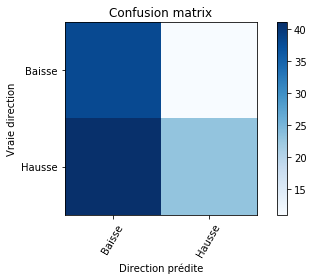

             precision    recall  f1-score   support

     Baisse       0.48      0.78      0.59        49
     Hausse       0.68      0.36      0.47        64

avg / total       0.59      0.54      0.52       113



In [519]:
from sklearn.metrics import confusion_matrix

clf = svm.SVC(kernel = 'rbf', gamma = 120, C = 1)
clf.fit(X,Y)
cm = confusion_matrix(list(Y_test) + list(Y_test_add), clf.predict(list(X_test) + list(X_test_add) ))
plot_confusion(cm)
print(classification_report(list(Y_test) + list(Y_test_add), clf.predict(list(X_test) + list(X_test_add)), target_names=['Baisse', 'Hausse']))

On trace la matrice de confusion du SVM à 13 caractéristiques avec les 20% de test set :

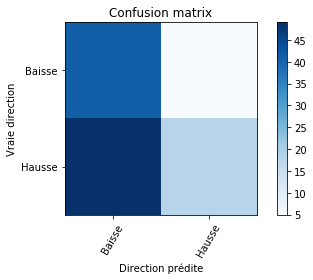

             precision    recall  f1-score   support

     Baisse       0.46      0.89      0.60        46
     Hausse       0.78      0.27      0.40        67

avg / total       0.65      0.52      0.48       113



In [520]:
from sklearn.metrics import confusion_matrix

pca = PCA(n_components = 8)
U_train_transfo = pca.fit_transform(U_train)
U_test_transfo = pca.transform(U_test + U_test_add)
clf = svm.SVC(kernel = 'rbf',gamma = 0.111, C = 10)
clf.fit(U_train_transfo, V_train)
cm = confusion_matrix(V_test + V_test_add, clf.predict(U_test_transfo))
plot_confusion(cm)
print(classification_report(V_test + V_test_add, clf.predict(U_test_transfo), target_names=['Baisse', 'Hausse']))

Les rappels (taux de bonne classification) sur les 2 matrices semblent à peu près équivalent. Cependant, le classifieur à 13 caractéristiques avce ACP a une meilleure précision globale (nombre de bonne classification d'une classe comparé au nombre de points attribué à cette classe) . C'est-à-dire que ce dernier a en général moins de chance de se tromper lors de ses prédictions (taux de confiance plus élevé).

Cette dernière propriété de précision est intéressante et semble mettre en évidence le caractère intemporel de ce classifieur SVM. Pour vérifier notre hypothèse on test la performance des 3 clasifieurs SVM (2 caractéristiques, 13 caractéristiques sans ACP et 13 caractéristiques avec ACP) à travers le temps sur une période test de 52 points (1 an). On entraine nos classifieurs sur la période d'entrainement puis on prédit les 52 points test qui suivent directement la fin de la période d'enrainement. Puis on réitère ce processus en décalant d'un jour le période des 52 points test (jusqu'à 60 semaine après la fin de la période d'entrainement).

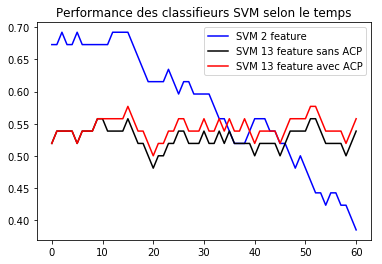

In [524]:
clf_2carac = svm.SVC(kernel = 'rbf', gamma = 120, C = 1)
clf_2carac.fit(X, Y)

clf_sans_acp = svm.SVC(kernel = 'rbf', gamma = 0.20, C = 10)
clf_sans_acp.fit(U_train, V_train)

pca = PCA(n_components = 8)
U_train_transfo = pca.fit_transform(U_train)
U_test_transfo = pca.transform(U_test + U_test_add)
clf_acp = svm.SVC(kernel = 'rbf', gamma = 0.111, C = 10)
clf_acp.fit(U_train_transfo, V_train)

plt.plot([clf_2carac.score((list(X_test) + list(X_test_add))[k:k+52] , (list(Y_test) + list(Y_test_add))[k:k+52]) for k in range(len(U_test_transfo)-52)], 'blue', label = "SVM 2 feature")
plt.plot([clf_sans_acp.score((U_test + U_test_add)[k:k+52] , (V_test + V_test_add)[k:k+52]) for k in range(len(U_test + U_test_add)-52)], 'black', label = "SVM 13 feature sans ACP")
plt.plot([clf_acp.score(U_test_transfo[k:k+52] , (V_test + V_test_add)[k:k+52]) for k in range(len(U_test_transfo)-52)], 'red', label = "SVM 13 feature avec ACP")

plt.title("Performance des classifieurs SVM selon le temps")
plt.legend()          
plt.show()

Le graphique ci dessus est sans equivoque : le simple SVM à 2 caractéristiques de l'article est fortement dépendant du temps. Seuls les points test les plus proches temporellement de notre période d'entrainement sont correctement classifiés. Avec le temps, le classifieur devient incompétent et ses anciennes données ne sont plus capable de prédire de nouveaux points tests. Par exemple, 15 semaines après la fin de l'entrainment, la performance sur 1 an chute drastiquement de plus de 10%. En revanche, nos nouveaux classifieurs mis en place à 13 caractéristiques semblent indépendant de la variable temporelle puisque qu'elle que soit la période test la performance du hit ratio varie toujours entre 51 et 57%.<br ><br />
D'autre part, on voit également la sur-performance à tout instant de l'application de l'ACP sur les 13 features (la courbe rouge est toujours au dessus de la courbe noire). Cette observation met en exergue le principe de parcimonie : apporter de nouvelles informations en plus à un jeu de donnée n'implique pas forcément une meilleure classification.<br ><br />
Enfin, on pourrait penser que seul ce classifieur SVM à 2 features pour ce couple de paramètre précis semble fortement dépendant au temps. Cependant, appliquer la même stratégie de prédiction précédente avec d'autres couples de paramètres ou d'autres classifieurs (LDA, QDA) implique toujours cette dépendance comme le montre le graphique ci dessous :

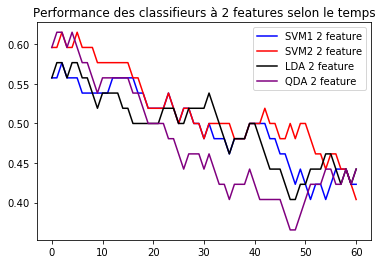

In [527]:
clf1 = svm.SVC(kernel = 'rbf', gamma = 1000, C = 1)
clf1.fit(X, Y)

clf2 = svm.SVC(kernel = 'rbf', gamma = 100, C = 10)
clf2.fit(X, Y)

clf_lda = LDA()
clf_lda.fit(X, Y)

clf_qda = QDA()
clf_qda.fit(X, Y)

plt.plot([clf1.score((list(X_test) + list(X_test_add))[k:k+52] , (list(Y_test) + list(Y_test_add))[k:k+52]) for k in range(len(U_test_transfo)-52)], 'blue', label = "SVM1 2 feature")
plt.plot([clf2.score((list(X_test) + list(X_test_add))[k:k+52] , (list(Y_test) + list(Y_test_add))[k:k+52]) for k in range(len(U_test_transfo)-52)], 'red', label = "SVM2 2 feature")
plt.plot([clf_lda.score((list(X_test) + list(X_test_add))[k:k+52] , (list(Y_test) + list(Y_test_add))[k:k+52]) for k in range(len(U_test_transfo)-52)], 'black', label = "LDA 2 feature")
plt.plot([clf_qda.score((list(X_test) + list(X_test_add))[k:k+52] , (list(Y_test) + list(Y_test_add))[k:k+52]) for k in range(len(U_test_transfo)-52)], 'purple', label = "QDA 2 feature")

plt.title("Performance des classifieurs à 2 features selon le temps")
plt.legend()          
plt.show()

Ainsi il est absolument primordial de bien classifier les premiers points test dans le cas d'un SVM à 2 caractéristiques puisque la performance des points test plus éloignés sera forcément réduite. C'est ce que l'article a réussi à faire en classant les 36 premiers points test (72% de réussite).<br ><br />
Cependant cette bonne performance est fortement corrélée à ce jeu de donnée précis pour cette période précise et n'est donc pas généralisable. En effet pour obtenir ce classifieur prédisant les 36 points test qui suivent, il a fallut choisir le meilleur couple de paramètre par cross validation. Cependant, au vu de notre méthode LOOCV, aucune séparation du train set prenant en compte la variable temporelle n'a été effectuée. L'auteur ne fait non plus nulle part mention d'une quelconque méthode prenant en compte le temps dans le choix des paramètres.<br ><br />

In [537]:
moyenne = np.mean([clf_acp.score(U_test_transfo[k:k+52] , (V_test + V_test_add)[k:k+52]) for k in range(len(U_test_transfo)-94)])
ecart = np.std([clf_acp.score(U_test_transfo[k:k+52] , (V_test + V_test_add)[k:k+52]) for k in range(len(U_test_transfo)-94)])

print("Performance moyenne et ecart type du SVM avec ACP à 13 features : \n{0}, {1}".format(moyenne, ecart))

Performance moyenne et ecart type du SVM avec ACP à 13 features : 
0.5455465587044536, 0.014242153116872758


En conclusion, nous avons implémenté une nouvelle méthode de prédiction du cours du Nikkei 225 généralisable à n'importe qu'elle période et apportant un taux de performance moyen de 0.546 pour un écart type de 0.014 avec une précision moyenne de 0.65%. Une simple stratégie de trading consistant à miser à la hausse ou à la baisse sur le cours du Nikkei 225 avec perte ou dédoublement de la mise permettrait d'engendrer un retour moyen sur investissement à l'année de 7.69% (28/52 direction bien classifiée) sans grande variation.